# <span style="color:#0b486b">Deep Neural Networks</span>

## <span style="color:#0b486b">Part 3: Convolutional Neural Networks and Image Classification</span>

**<div style="text-align: right"><span style="color:red">[Total marks for this part: 45 points]</span></div>**

**The dataset used for this part is a specific dataset for this unit consisting of approximately $10,000$ images of $20$ classes of Animals, each of which has approximately 500 images. You can download the dataset at [download here](https://drive.google.com/file/d/1aEkxNWaD02Z8ZNvZzeMefUoY97C-3wTG/view?usp=drive_link) if you want to do your assignment on your machine.**


In [1]:
import os
import requests
import tarfile
import time
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import torchvision.models as models
import torch.nn as nn
import torch
import PIL.Image
import pathlib
from torchsummary import summary
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

# check if CUDA is available
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.manual_seed(1234)

CUDA is available!  Training on GPU ...


Download the dataset to the folder of this Google Colab.

In [2]:
!gdown --fuzzy https://drive.google.com/file/d/1qdElRqDS4TitXfv_iG_TFQSi9QIfy4uM/view?usp=drive_link # backup url


Downloading...
From (original): https://drive.google.com/uc?id=1qdElRqDS4TitXfv_iG_TFQSi9QIfy4uM
From (redirected): https://drive.google.com/uc?id=1qdElRqDS4TitXfv_iG_TFQSi9QIfy4uM&confirm=t&uuid=19b0472c-52b4-48a6-a890-b1073e241a98
To: /content/Animals_Dataset.zip
100% 643M/643M [00:04<00:00, 131MB/s]


We unzip the dataset to the folder.

In [3]:
!unzip -q Animals_Dataset.zip

In [4]:
data_dir = "./FIT5215_Dataset"

# We resize the images to [3,64,64]
transform = transforms.Compose([transforms.Resize((64,64)),  #resises the image so it can be perfect for our model.
                                      transforms.RandomHorizontalFlip(), # FLips the image w.r.t horizontal axis
                                      #transforms.RandomRotation(4),     #Rotates the image to a specified angel
                                      #transforms.RandomAffine(0, shear=10, scale=(0.8,1.2)), #Performs actions like zooms, change shear angles.
                                      transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2), # Set the color params
                                      transforms.ToTensor(), # convert the image to tensor so that it can work with torch
                                      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),  # Normalize the images, each R,G,B value is normalized with mean=0.5 and std=0.5
                                      ])


# Load the dataset using torchvision.datasets.ImageFolder and apply transformations
dataset = datasets.ImageFolder(data_dir, transform=transform)

# Split the dataset into training and validation sets
train_size = int(0.9 * len(dataset))
valid_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, valid_size])

# Example of DataLoader creation for training and validation
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

print("Number of instance in train_set: %s" % len(train_dataset))
print("Number of instance in val_set: %s" % len(val_dataset))

Number of instance in train_set: 8519
Number of instance in val_set: 947


In [5]:
class_names = ['bird', 'bottle', 'bread', 'butterfly', 'cake', 'cat', 'chicken', 'cow', 'dog', 'duck',
                  'elephant', 'fish', 'handgun', 'horse', 'lion', 'lipstick', 'seal', 'snake', 'spider', 'vase']

In [6]:
# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = next(dataiter)
images = images.numpy() # convert images to numpy for display

In [7]:
import math

def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    plt.imshow(np.transpose(img, (1, 2, 0)))  # convert from Tensor image

def visualize_data(images, categories, images_per_row = 8):
    class_names = ['bird', 'bottle', 'bread', 'butterfly', 'cake', 'cat', 'chicken', 'cow', 'dog', 'duck',
                  'elephant', 'fish', 'handgun', 'horse', 'lion', 'lipstick', 'seal', 'snake', 'spider', 'vase']
    n_images = len(images)
    n_rows = math.ceil(float(n_images)/images_per_row)
    fig = plt.figure(figsize=(1.5*images_per_row, 1.5*n_rows))
    fig.patch.set_facecolor('white')
    for i in range(n_images):
        plt.subplot(n_rows, images_per_row, i+1)
        plt.xticks([])
        plt.yticks([])
        imshow(images[i])
        class_index = categories[i]
        plt.xlabel(class_names[class_index])
    plt.show()

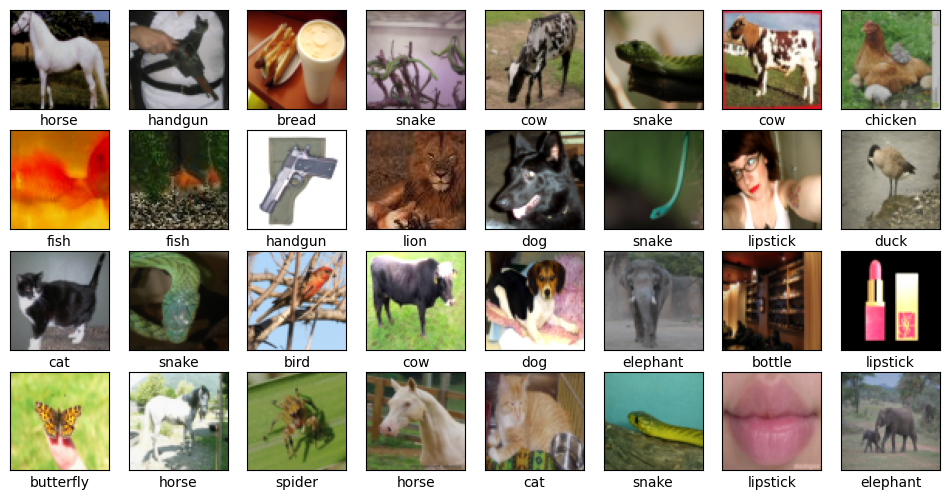

In [8]:
visualize_data(images, labels)

In [9]:
test_loader = val_loader

In [10]:
import torch
import pandas as pd

def save_prediction_to_csv(model, loader, device, output_file="submission.csv"):
    model.eval()
    predictions = []
    image_ids = []
    df = {
    "ID": [],
    "Label": []
    }
    total = 0
    with torch.no_grad():
        for i, (batchX, batchY) in enumerate(loader):
            batchX, batchY = batchX.to(device), batchY.to(device)
            outputs = model(batchX.float())  # Convert to float32 and feed batch to the model
            predicted = torch.argmax(outputs, dim=1)  # Get the predicted class
            total += predicted.size(0)
            for ids, pred in enumerate(predicted):
                label = class_names[pred.to(device).item()]
                df["ID"].append(i*500+ids)
                df["Label"].append(label)
    df["ID"] = [i for i in range(total)]
    # Create a DataFrame
    df = pd.DataFrame(df)
    # Save to CSV
    df.to_csv(output_file, index=False)

**For questions 3.1 to 3.7, you'll need to write your own model in a way that makes it easy for you to experiment with different architectures and parameters. The goal is to be able to pass the parameters to initialize a new instance of `YourModel` to build different network architectures with different parameters. Below are descriptions of some parameters for `YourModel`:**

1. `Block confirguration`: Our network consists of many blocks. Each block has the pattern `[conv, batch norm, activation, conv, batch norm, activation, max pool, dropout]`. All convolutional layers have filter size $(3, 3)$, strides $(1, 1)$ and padding = 1, and all max pool layers have strides $(2, 2)$, kernel size $2$, and padding = 0. The network will consists of a few blocks before applying a linear layer to output the logits for the softmax layer.

2. `list_feature_maps`: the number of feature maps in the blocks of the network. For example, if `list_feature_maps = [16, 32, 64]`, our network has two blocks with the input_channels or number of feature maps are `16, 32`, and `64` respectively.
3. `drop_rate`: the keep probability for dropout. Setting `drop_rate` to $0.0$ means not using dropout.
4. `batch_norm`: the batch normalization function is used or not. Setting `batch_norm` to `false` means not using batch normalization.
5. `use_skip`: the skip connection is used in the blocks or not. Setting this to `true` means that we use `1x1` Conv2D with `strides=2` for the skip connection.
6. At the end, you need to apply `global average pooling (GAP)` (`AdaptiveAvgPool2d((1, 1))`) to flatten the 3D output tensor before defining the output linear layer for predicting the labels.



Here is the model confirguration of `YourCNN` if the `list_feature_maps = [16, 32, 64]` and `batch_norm = true`.

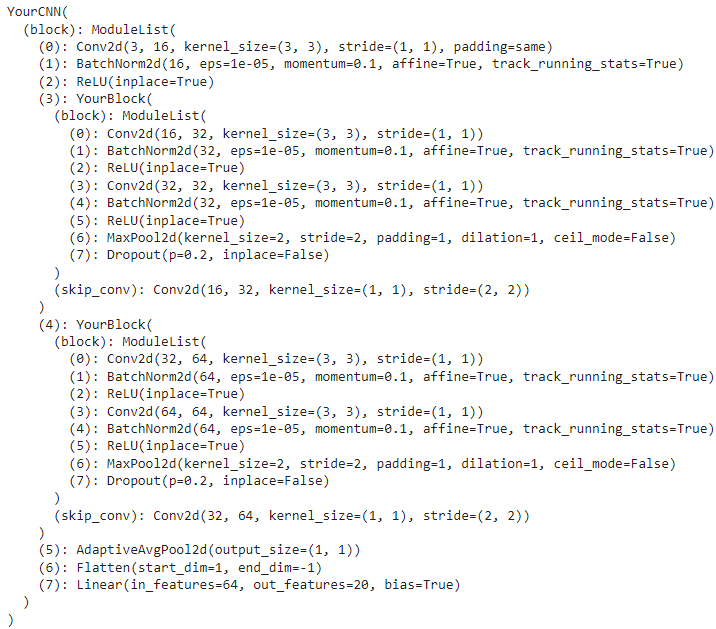

<span style="color:red">**Question 3.1:**</span> **You need to implement the aforementioned CNN**.

**First, you need to implement the block of our CNN in the class `YourBlock`. You can ignore `use_skip` and `skip connection` for simplicity. However, you cannot earn full marks for this question.**

<div style="text-align: right"> <span style="color:red">[6 points]</span> </div>

In [11]:
class YourBlock(nn.Module):
    def __init__(self, in_feature_maps, out_feature_maps, drop_rate = 0.2, batch_norm = True, use_skip = True):
        super(YourBlock, self).__init__()
        self.use_skip = use_skip



        self.block = nn.Sequential(
            nn.Conv2d(in_feature_maps, out_feature_maps, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(out_feature_maps) if batch_norm else nn.Identity(),
            nn.ReLU(),
            nn.Conv2d(out_feature_maps, out_feature_maps, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(out_feature_maps) if batch_norm else nn.Identity(),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0),
            nn.Dropout(drop_rate)
        )


        if use_skip:
            self.skip_connection = nn.Conv2d(in_feature_maps, out_feature_maps, kernel_size=1, stride=2, padding=0)
        else:
            self.skip_connection = None

    def forward(self, x):
        residual = x

        x = self.block(x)

        if self.skip_connection:
            residual = self.skip_connection(residual)
            x += residual

        return x




**Second, you need to use the above `YourBlock` to implement the class `YourCNN`**.

<div style="text-align: right"> <span style="color:red">[6 points]</span> </div>

In [12]:
class YourCNN(nn.Module):
    def __init__(self, list_feature_maps = [16, 32, 64], drop_rate = 0.2, batch_norm= True, use_skip = True):
        super(YourCNN, self).__init__()
        layers = []

        in_channels = 3

        layers.append(nn.Conv2d(in_channels, list_feature_maps[0], kernel_size=3, stride=1, padding=1))
        if batch_norm:
            layers.append(nn.BatchNorm2d(list_feature_maps[0]))
        layers.append(nn.ReLU())


        for i in range(len(list_feature_maps) - 1):
            layers.append(YourBlock(list_feature_maps[i], list_feature_maps[i + 1], drop_rate, batch_norm, use_skip))

        self.blocks = nn.ModuleList(layers)


        self.gap = nn.AdaptiveAvgPool2d((1, 1))


        self.fc = nn.Linear(list_feature_maps[-1], 20)

    def forward(self, x):
        for block in self.blocks:
            x = block(x)

        x = self.gap(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x


**We declare `my_cnn` from `YourCNN` as follows**.

In [13]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
my_cnn = YourCNN(list_feature_maps = [16, 32, 64], use_skip = True)
my_cnn = my_cnn.to(device)
print(my_cnn)

YourCNN(
  (blocks): ModuleList(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): YourBlock(
      (block): Sequential(
        (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
        (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): ReLU()
        (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        (7): Dropout(p=0.2, inplace=False)
      )
      (skip_connection): Conv2d(16, 32, kernel_size=(1, 1), stride=(2, 2))
    )
    (4): YourBlock(
      (block): Sequential(
        (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1)

**We declare the optimizer and the loss function.**

In [14]:

learning_rate = 0.001
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(my_cnn.parameters(), lr=learning_rate)

**Here are the codes to compute the loss and accuracy.**

In [15]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

def compute_loss(model, loss_fn, loader):
  loss = 0

  model.eval()
  with torch.no_grad():
    for (batchX, batchY) in loader:

      batchX, batchY = batchX.to(device).type(torch.float32), batchY.to(device).type(torch.long)
      loss += loss_fn(model(batchX), batchY)

  model.train()
  return float(loss)/len(loader)

In [16]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

def compute_acc(model, loader):
    correct = 0
    totals = 0

    model.eval()
    for (batchX, batchY) in loader:

        batchX, batchY = batchX.to(device).type(torch.float32), batchY.to(device)
        outputs = model(batchX)
        totals += batchY.size(0)
        predicted = torch.argmax(outputs.data, 1)

        correct += (predicted == batchY).sum().item()
    return correct / totals

**Here is the code to train our model.**

In [17]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

def fit(model= None, train_loader = None, valid_loader= None, optimizer = None,
        num_epochs = 20, verbose = True, seed= 1234):
  torch.manual_seed(seed)
  # Move the model to the device before initializing the optimizer
  model.to(device) # Move the model to the GPU

  if optimizer == None:
    optim = torch.optim.Adam(model.parameters(), lr = 0.001) # Now initialize optimizer with model on GPU
  else:
    optim = optimizer
  history = dict()
  history['val_loss'] = list()
  history['val_acc'] = list()
  history['train_loss'] = list()
  history['train_acc'] = list()

  for epoch in range(num_epochs):
    model.train()
    for (X, y) in train_loader:
      # Move input data to the same device as the model
      X,y = X.to(device), y.to(device)
      # Forward pass
      outputs = model(X.type(torch.float32))
      loss = loss_fn(outputs, y.type(torch.long))
      # Backward and optimize
      optim.zero_grad()
      loss.backward()
      optim.step()
      #losses and accuracies for epoch
    val_loss = compute_loss(model, loss_fn, valid_loader)
    val_acc = compute_acc(model, valid_loader)
    train_loss = compute_loss(model, loss_fn, train_loader)
    train_acc = compute_acc(model, train_loader)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    if not verbose:
      print(f"Epoch {epoch+1}/{num_epochs}")
      print(f"train loss= {train_loss:.4f} - train acc= {train_acc*100:.2f}% - valid loss= {val_loss:.4f} - valid acc= {val_acc*100:.2f}%")
  return history

In [ ]:
history = fit(model= my_cnn, train_loader=train_loader, valid_loader = val_loader, optimizer = optimizer, num_epochs= 20, verbose = False)

Epoch 1/20
train loss= 2.4857 - train acc= 24.37% - valid loss= 2.4707 - valid acc= 23.65%
Epoch 2/20
train loss= 2.0943 - train acc= 33.14% - valid loss= 2.1598 - valid acc= 29.99%
Epoch 3/20
train loss= 1.9140 - train acc= 39.78% - valid loss= 1.9895 - valid acc= 37.06%
Epoch 4/20
train loss= 1.7849 - train acc= 44.57% - valid loss= 1.8214 - valid acc= 44.03%
Epoch 5/20
train loss= 1.8637 - train acc= 42.79% - valid loss= 1.9080 - valid acc= 40.13%
Epoch 6/20
train loss= 1.6394 - train acc= 48.23% - valid loss= 1.6708 - valid acc= 47.41%
Epoch 7/20
train loss= 1.6132 - train acc= 49.62% - valid loss= 1.6489 - valid acc= 48.05%
Epoch 8/20
train loss= 1.4371 - train acc= 55.21% - valid loss= 1.4620 - valid acc= 53.54%
Epoch 9/20
train loss= 1.5700 - train acc= 50.23% - valid loss= 1.6119 - valid acc= 48.36%
Epoch 10/20
train loss= 1.5611 - train acc= 50.52% - valid loss= 1.6549 - valid acc= 47.52%
Epoch 11/20
train loss= 1.3972 - train acc= 55.31% - valid loss= 1.4757 - valid acc= 53.3

<span style="color:red">**Question 3.2:**</span> **Now, let us tune the number of blocks $use\_skip \in \{true,false\}$ and $learning\_rate \in \{0.001, 0.0005\}$. Write your code for this tuning and report the result of the best model on the testing set. Note that you need to show your code for tuning and evaluating on the test set to earn the full marks. During tuning, you can set the instance variable `verbose` of your model to `True` for not showing the training details of each epoch.**

Note that for this question, depending on your computational resource, you can choose `list_feature_maps= [32, 64]` or `list_feature_maps= [16, 32, 64]`.

<div style="text-align: right"> <span style="color:red">[3 points]</span> </div>

In [ ]:
import torch.optim as optim
list_feature_maps_options = [[16,32,64]]
use_skip_options = [True, False]
learning_rate_options = [0.001, 0.0005]
num_epochs = 20

# Initialize variables to track the best model
best_model = None
best_val_acc = 0
best_params = {}

for list_feature_maps in list_feature_maps_options:
    for use_skip in use_skip_options:
        for learning_rate in learning_rate_options:
            print(f"Training with list_feature_maps={list_feature_maps}, use_skip={use_skip}, learning_rate={learning_rate}")

            # Initialize the model
            model = YourCNN(list_feature_maps, drop_rate=0.2, batch_norm=True, use_skip=use_skip)

            # Define the optimizer
            optimizer = optim.Adam(model.parameters(), lr=learning_rate)

            # Train the model
            history = fit(model=model, train_loader=train_loader, valid_loader=val_loader, optimizer=optimizer, num_epochs=num_epochs, verbose=False)

            # Evaluate the model on validation set
            val_acc = history['val_acc'][-1]
            print(f"Validation accuracy: {val_acc*100:.2f}%")

            # Check if this model is the best one so far
            if val_acc > best_val_acc:
                best_val_acc = val_acc
                best_model = model
                best_params = {
                    'list_feature_maps': list_feature_maps,
                    'use_skip': use_skip,
                    'learning_rate': learning_rate
                }

# Report the best model
print(f"Best model parameters: {best_params}")
print(f"Best validation accuracy: {best_val_acc*100:.2f}%")

# Test the best model
test_acc = compute_acc(best_model, test_loader)
print(f"Test accuracy of the best model: {test_acc*100:.2f}%")

Training with list_feature_maps=[16, 32, 64], use_skip=True, learning_rate=0.001
Epoch 1/20
train loss= 2.3138 - train acc= 28.74% - valid loss= 2.3167 - valid acc= 28.83%
Epoch 2/20
train loss= 2.0115 - train acc= 35.56% - valid loss= 2.0688 - valid acc= 33.26%
Epoch 3/20
train loss= 1.8340 - train acc= 42.61% - valid loss= 1.8989 - valid acc= 40.76%
Epoch 4/20
train loss= 1.7003 - train acc= 45.76% - valid loss= 1.7781 - valid acc= 42.98%
Epoch 5/20
train loss= 1.8497 - train acc= 43.39% - valid loss= 1.8712 - valid acc= 41.50%
Epoch 6/20
train loss= 1.6574 - train acc= 47.19% - valid loss= 1.6833 - valid acc= 46.36%
Epoch 7/20
train loss= 1.5723 - train acc= 51.71% - valid loss= 1.6094 - valid acc= 50.79%
Epoch 8/20
train loss= 1.4049 - train acc= 55.98% - valid loss= 1.4043 - valid acc= 55.12%
Epoch 9/20
train loss= 1.4068 - train acc= 54.85% - valid loss= 1.4516 - valid acc= 54.38%
Epoch 10/20
train loss= 1.4587 - train acc= 52.83% - valid loss= 1.5380 - valid acc= 49.84%
Epoch 11

**Please note that if you struggle in implementing the aforementioned CNN, you can use the MiniVGG network in our labs for doing the following questions. However, you do not earn marks for 3.1 and 3.2.**

<span style="color:red">**Question 3.3:**</span> **Exploring Data Mixup Technique for Improving Generalization Ability.**
   
<div style="text-align: right"> <span style="color:red">[4 points]</span> </div>

Data mixup is another super-simple technique used to boost the generalization ability of deep learning models. You need to incoroporate data mixup technique to the above deep learning model and experiment its performance. There are some papers and documents for data mixup as follows:
- Main paper for data mixup [link for main paper](https://openreview.net/pdf?id=r1Ddp1-Rb) and a good article [article link](https://www.inference.vc/mixup-data-dependent-data-augmentation/).

You need to extend your model developed above, train a model using data mixup, and write your observations and comments about the result.

In [ ]:
#Your code here
def mixup_data(x, y, alpha=0.4):
    """Apply mixup to the data."""
    if alpha <= 0:
        return x, y
    lam = np.random.beta(alpha, alpha)
    batch_size = x.size(0)
    index = torch.randperm(batch_size).to(x.device)
    mixed_x = lam * x + (1 - lam) * x[index, :]
    mixed_y = lam * y + (1 - lam) * y[index]
    return mixed_x, mixed_y


In [ ]:
def fit_with_mixup(model=None, train_loader=None, valid_loader=None, optimizer=None,
                   num_epochs=20, alpha=0.4, verbose=True, seed=1234):
    torch.manual_seed(seed)
    model.to(device)

    if optimizer is None:
        optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    history = {
        'val_loss': [],
        'val_acc': [],
        'train_loss': [],
        'train_acc': []
    }

    for epoch in range(num_epochs):
        model.train()
        for (X, y) in train_loader:
            X, y = X.to(device), y.to(device)
            # Apply mixup
            X, y = mixup_data(X, y, alpha)
            outputs = model(X.type(torch.float32))
            loss = loss_fn(outputs, y.type(torch.long))
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        val_loss = compute_loss(model, loss_fn, valid_loader)
        val_acc = compute_acc(model, valid_loader)
        train_loss = compute_loss(model, loss_fn, train_loader)
        train_acc = compute_acc(model, train_loader)

        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)

        if verbose:
            print(f"Epoch {epoch+1}/{num_epochs}")
            print(f"train loss= {train_loss:.4f} - train acc= {train_acc*100:.2f}% - "
                  f"valid loss= {val_loss:.4f} - valid acc= {val_acc*100:.2f}%")

    return history

In [ ]:
alpha = 0.4

# Initialize the model
model_with_mixup = YourCNN(list_feature_maps, drop_rate=0.2, batch_norm=True, use_skip=True)

# Define the optimizer
optimizer_with_mixup = optim.Adam(model_with_mixup.parameters(), lr=0.001)

# Train the model with mixup
history_with_mixup = fit_with_mixup(model=model_with_mixup, train_loader=train_loader, valid_loader=val_loader,
                                     optimizer=optimizer_with_mixup, num_epochs=20, alpha=alpha, verbose=True)

# Evaluate the model with mixup on the test set
test_acc_with_mixup = compute_acc(model_with_mixup, test_loader)
print(f"Test accuracy with mixup: {test_acc_with_mixup*100:.2f}%")

Epoch 1/20
train loss= 2.8867 - train acc= 9.07% - valid loss= 2.8698 - valid acc= 12.25%
Epoch 2/20
train loss= 2.7682 - train acc= 15.47% - valid loss= 2.7731 - valid acc= 15.21%
Epoch 3/20
train loss= 2.6165 - train acc= 22.02% - valid loss= 2.6240 - valid acc= 22.39%
Epoch 4/20
train loss= 2.6420 - train acc= 19.32% - valid loss= 2.6309 - valid acc= 19.85%
Epoch 5/20
train loss= 2.5809 - train acc= 20.41% - valid loss= 2.5876 - valid acc= 21.01%
Epoch 6/20
train loss= 2.6296 - train acc= 22.09% - valid loss= 2.6181 - valid acc= 22.60%
Epoch 7/20
train loss= 2.5785 - train acc= 20.66% - valid loss= 2.5797 - valid acc= 22.07%
Epoch 8/20
train loss= 2.4767 - train acc= 21.99% - valid loss= 2.4807 - valid acc= 21.75%
Epoch 9/20
train loss= 2.4070 - train acc= 28.22% - valid loss= 2.4256 - valid acc= 27.03%
Epoch 10/20
train loss= 2.4563 - train acc= 21.18% - valid loss= 2.4704 - valid acc= 21.12%
Epoch 11/20
train loss= 2.4243 - train acc= 23.25% - valid loss= 2.4391 - valid acc= 21.01

<span style="color:red">**Question 3.4:**</span> **Exploring CutMix Technique for Improving Generalization Ability.**
   
<div style="text-align: right"> <span style="color:red">[4 points]</span> </div>

Data mixup is another super-simple technique used to boost the generalization ability of deep learning models. You need to incoroporate data mixup technique to the above deep learning model and experiment its performance. There are some papers and documents for data mixup as follows:
- Main paper for Cutmix [link for main paper](https://arxiv.org/pdf/1905.04899v2) and a good article [article link](https://shorturl.at/TNwjv).

You need to extend your model developed above, train a model using Cutmix, and write your observations and comments about the result.

In [ ]:
def cutmix_data(x, y, alpha=1.0):
    """Apply CutMix to the data."""
    if alpha <= 0:
        return x, y

    batch_size = x.size(0)
    indices = torch.randperm(batch_size).to(x.device)

    lam = np.random.beta(alpha, alpha)

    # Choose random locations and sizes for the cut
    width, height = x.size(2), x.size(3)
    cut_rat = np.sqrt(1. - lam)
    cut_w = int(width * cut_rat)
    cut_h = int(height * cut_rat)

    # Randomly choose top-left corner of the cut box
    cx = np.random.randint(width)
    cy = np.random.randint(height)

    # Make sure the cut is within the image boundaries
    bbx1 = np.clip(cx - cut_w // 2, 0, width)
    bby1 = np.clip(cy - cut_h // 2, 0, height)
    bbx2 = np.clip(cx + cut_w // 2, 0, width)
    bby2 = np.clip(cy + cut_h // 2, 0, height)

    # Create the mixed images and labels
    x_cutmix = x.clone()
    y_cutmix = y.clone()
    x_cutmix[:, :, bby1:bby2, bbx1:bbx2] = x[indices, :, bby1:bby2, bbx1:bbx2]
    y_cutmix = lam * y + (1 - lam) * y[indices]

    return x_cutmix, y_cutmix


In [ ]:
def fit_with_cutmix(model=None, train_loader=None, valid_loader=None, optimizer=None,
                    num_epochs=20, alpha=1.0, verbose=True, seed=1234):
    torch.manual_seed(seed)
    model.to(device)

    if optimizer is None:
        optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    history = {
        'val_loss': [],
        'val_acc': [],
        'train_loss': [],
        'train_acc': []
    }

    for epoch in range(num_epochs):
        model.train()
        for (X, y) in train_loader:
            X, y = X.to(device), y.to(device)
            # Apply CutMix
            X, y = cutmix_data(X, y, alpha)
            outputs = model(X.type(torch.float32))
            loss = loss_fn(outputs, y.type(torch.long))
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        val_loss = compute_loss(model, loss_fn, valid_loader)
        val_acc = compute_acc(model, valid_loader)
        train_loss = compute_loss(model, loss_fn, train_loader)
        train_acc = compute_acc(model, train_loader)

        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)

        if verbose:
            print(f"Epoch {epoch+1}/{num_epochs}")
            print(f"train loss= {train_loss:.4f} - train acc= {train_acc*100:.2f}% - "
                  f"valid loss= {val_loss:.4f} - valid acc= {val_acc*100:.2f}%")

    return history

In [ ]:
alpha = 1.0

# Initialize the model
model_with_cutmix = YourCNN(list_feature_maps, drop_rate=0.2, batch_norm=True, use_skip=True)

# Define the optimizer
optimizer_with_cutmix = optim.Adam(model_with_cutmix.parameters(), lr=0.001)

# Train the model with CutMix
history_with_cutmix = fit_with_cutmix(model=model_with_cutmix, train_loader=train_loader, valid_loader=val_loader,
                                       optimizer=optimizer_with_cutmix, num_epochs=20, alpha=alpha, verbose=True)

# Evaluate the model with CutMix on the test set
test_acc_with_cutmix = compute_acc(model_with_cutmix, test_loader)
print(f"Test accuracy with CutMix: {test_acc_with_cutmix*100:.2f}%")

Epoch 1/20
train loss= 2.9642 - train acc= 10.93% - valid loss= 2.9490 - valid acc= 10.45%
Epoch 2/20
train loss= 2.8298 - train acc= 14.77% - valid loss= 2.8344 - valid acc= 15.95%
Epoch 3/20
train loss= 2.7881 - train acc= 17.34% - valid loss= 2.8003 - valid acc= 18.48%
Epoch 4/20
train loss= 2.9337 - train acc= 11.30% - valid loss= 2.9408 - valid acc= 10.35%
Epoch 5/20
train loss= 2.8168 - train acc= 15.75% - valid loss= 2.8308 - valid acc= 16.16%
Epoch 6/20
train loss= 2.7151 - train acc= 17.98% - valid loss= 2.7140 - valid acc= 16.26%
Epoch 7/20
train loss= 2.6940 - train acc= 17.38% - valid loss= 2.6986 - valid acc= 17.00%
Epoch 8/20
train loss= 2.6665 - train acc= 17.08% - valid loss= 2.6694 - valid acc= 16.58%
Epoch 9/20
train loss= 2.6855 - train acc= 23.12% - valid loss= 2.6919 - valid acc= 21.65%
Epoch 10/20
train loss= 2.6089 - train acc= 20.59% - valid loss= 2.6123 - valid acc= 17.95%
Epoch 11/20
train loss= 2.5792 - train acc= 21.60% - valid loss= 2.5863 - valid acc= 21.4

My observations and comments: While CutMix improved the generalization capability of the model, its full potential may not have been realized due to the relatively short training period and model complexity. Further fine-tuning and experimentation are recommended to fully leverage the benefits of this augmentation technique.

<span style="color:red">**Question 3.5:**</span> Implement the **one-versus-all (OVA)** loss. The details are as follows:
- You need to apply `the sigmoid activation function` to logits $h = [h_1, h_2,...,h_M]$ instead of `the softmax activation` function as usual to obtain $p = [p_1, p_2,...,p_M]$, meaning that $p_i = sigmoid(h_i), i=1,...,M$. Note that $M$ is the number of classes.
- Given a data example $x$ with the ground-truth label $y$, the idea is to maximize the likelihood $p_y$ and to minimize the likelihoods $p_i, i \neq y$. Therefore, the objective function is to find the model parameters to
  - $\max\left\{ \log p_{y}+\sum_{i\neq y}\log(1-p_{i})\right\}$ or equivalently $\min\left\{ -\log p_{y}-\sum_{i\neq y}\log(1-p_{i})\right\}$.
  - For example, if $M=3$ and $y=2$, you need to minimize $\min\left\{ -\log(1-p_{1})-\log p_{2}-\log(1-p_{3})\right\}$.

Compare the model trained with the OVA loss and the same model trained with the standard cross-entropy loss.

<div style="text-align: right"> <span style="color:red">[4 points]</span> </div>



In [ ]:
class OVALoss(nn.Module):
    def __init__(self):
        super(OVALoss, self).__init__()

    def forward(self, logits, targets):
        """
        Compute the One-Versus-All (OVA) loss.

        Parameters:
        logits (Tensor): The raw outputs from the model (before activation), shape [batch_size, num_classes].
        targets (Tensor): The ground truth labels, shape [batch_size].

        Returns:
        Tensor: The computed OVA loss.
        """
        # Apply sigmoid activation
        probs = torch.sigmoid(logits)

        # Convert targets to one-hot encoding
        batch_size = logits.size(0)
        num_classes = logits.size(1)
        one_hot_targets = torch.zeros(batch_size, num_classes).to(logits.device)
        one_hot_targets.scatter_(1, targets.unsqueeze(1), 1)

        # Compute OVA loss
        loss = - (one_hot_targets * torch.log(probs + 1e-8) + (1 - one_hot_targets) * torch.log(1 - probs + 1e-8)).sum(dim=1).mean()
        return loss



In [ ]:
def fit_with_ova_loss(model, train_loader, valid_loader, optimizer, num_epochs=20, verbose=True, seed=1234):
    torch.manual_seed(seed)
    model.to(device)

    loss_fn = OVALoss()

    history = {
        'val_loss': [],
        'val_acc': [],
        'train_loss': [],
        'train_acc': []
    }

    for epoch in range(num_epochs):
        model.train()
        for (X, y) in train_loader:
            X, y = X.to(device), y.to(device)
            outputs = model(X.type(torch.float32))
            loss = loss_fn(outputs, y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        val_loss = compute_loss(model, loss_fn, valid_loader)
        val_acc = compute_acc(model, valid_loader)
        train_loss = compute_loss(model, loss_fn, train_loader)
        train_acc = compute_acc(model, train_loader)

        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)

        if verbose:
            print(f"Epoch {epoch+1}/{num_epochs}")
            print(f"train loss= {train_loss:.4f} - train acc= {train_acc*100:.2f}% - "
                  f"valid loss= {val_loss:.4f} - valid acc= {val_acc*100:.2f}%")

    return history

In [ ]:
model_with_ova = YourCNN(list_feature_maps = [16, 32, 64], drop_rate=0.2, batch_norm=True, use_skip=True)
optimizer_with_ova = torch.optim.Adam(model_with_ova.parameters(), lr=0.001)

# Train the model with OVA loss
history_with_ova = fit_with_ova_loss(model=model_with_ova, train_loader=train_loader, valid_loader=val_loader,
                                      optimizer=optimizer_with_ova, num_epochs=20, verbose=True)

# Evaluate the model with OVA loss on the test set
test_acc_with_ova = compute_acc(model_with_ova, test_loader)
print(f"Test accuracy with OVA loss: {test_acc_with_ova*100:.2f}%")

Epoch 1/20
train loss= 3.3259 - train acc= 26.19% - valid loss= 3.3526 - valid acc= 24.50%
Epoch 2/20
train loss= 3.1106 - train acc= 30.91% - valid loss= 3.1392 - valid acc= 29.67%
Epoch 3/20
train loss= 2.8797 - train acc= 38.98% - valid loss= 2.9182 - valid acc= 38.75%
Epoch 4/20
train loss= 2.7855 - train acc= 41.80% - valid loss= 2.8456 - valid acc= 40.13%
Epoch 5/20
train loss= 2.7106 - train acc= 43.16% - valid loss= 2.7581 - valid acc= 40.87%
Epoch 6/20
train loss= 2.6419 - train acc= 45.52% - valid loss= 2.6762 - valid acc= 43.82%
Epoch 7/20
train loss= 2.6343 - train acc= 47.21% - valid loss= 2.6770 - valid acc= 46.99%
Epoch 8/20
train loss= 2.5332 - train acc= 49.28% - valid loss= 2.5161 - valid acc= 49.21%
Epoch 9/20
train loss= 2.5329 - train acc= 46.93% - valid loss= 2.6206 - valid acc= 44.98%
Epoch 10/20
train loss= 2.5018 - train acc= 48.67% - valid loss= 2.5895 - valid acc= 46.99%
Epoch 11/20
train loss= 2.3751 - train acc= 52.93% - valid loss= 2.4403 - valid acc= 49.8

In [18]:
list_feature_maps = [16, 32, 64]

In [ ]:
cross_entropy_loss_fn = nn.CrossEntropyLoss()

def fit_with_cross_entropy(model, train_loader, valid_loader, optimizer, num_epochs=20, verbose=True, seed=1234):
    torch.manual_seed(seed)
    model.to(device)

    history = {
        'val_loss': [],
        'val_acc': [],
        'train_loss': [],
        'train_acc': []
    }

    for epoch in range(num_epochs):
        model.train()
        for (X, y) in train_loader:
            X, y = X.to(device), y.to(device)
            outputs = model(X.type(torch.float32))
            loss = cross_entropy_loss_fn(outputs, y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        val_loss = compute_loss(model, cross_entropy_loss_fn, valid_loader)
        val_acc = compute_acc(model, valid_loader)
        train_loss = compute_loss(model, cross_entropy_loss_fn, train_loader)
        train_acc = compute_acc(model, train_loader)

        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)

        if verbose:
            print(f"Epoch {epoch+1}/{num_epochs}")
            print(f"train loss= {train_loss:.4f} - train acc= {train_acc*100:.2f}% - "
                  f"valid loss= {val_loss:.4f} - valid acc= {val_acc*100:.2f}%")

    return history

# Initialize the model and optimizer
model_with_cross_entropy = YourCNN(list_feature_maps, drop_rate=0.2, batch_norm=True, use_skip=True)
optimizer_with_cross_entropy = torch.optim.Adam(model_with_cross_entropy.parameters(), lr=0.001)

# Train the model with cross-entropy loss
history_with_cross_entropy = fit_with_cross_entropy(model=model_with_cross_entropy, train_loader=train_loader, valid_loader=val_loader,
                                                    optimizer=optimizer_with_cross_entropy, num_epochs=20, verbose=True)

# Evaluate the model with cross-entropy loss on the test set
test_acc_with_cross_entropy = compute_acc(model_with_cross_entropy, test_loader)
print(f"Test accuracy with cross-entropy loss: {test_acc_with_cross_entropy*100:.2f}%")

Epoch 1/20
train loss= 2.3144 - train acc= 28.28% - valid loss= 2.3262 - valid acc= 29.57%
Epoch 2/20
train loss= 2.0739 - train acc= 33.75% - valid loss= 2.1060 - valid acc= 31.57%
Epoch 3/20
train loss= 2.0554 - train acc= 35.39% - valid loss= 2.0763 - valid acc= 35.80%
Epoch 4/20
train loss= 1.7217 - train acc= 46.04% - valid loss= 1.7675 - valid acc= 43.40%
Epoch 5/20
train loss= 1.7935 - train acc= 43.04% - valid loss= 1.8419 - valid acc= 40.13%
Epoch 6/20
train loss= 1.6795 - train acc= 46.11% - valid loss= 1.7311 - valid acc= 44.88%
Epoch 7/20
train loss= 1.6352 - train acc= 48.69% - valid loss= 1.6851 - valid acc= 48.15%
Epoch 8/20
train loss= 1.4626 - train acc= 53.73% - valid loss= 1.4889 - valid acc= 51.74%
Epoch 9/20
train loss= 1.4185 - train acc= 55.05% - valid loss= 1.4701 - valid acc= 52.16%
Epoch 10/20
train loss= 1.5740 - train acc= 49.43% - valid loss= 1.6572 - valid acc= 46.88%
Epoch 11/20
train loss= 1.4221 - train acc= 54.18% - valid loss= 1.5048 - valid acc= 51.5

<span style="color:red">**Question 3.6:**</span> **Attack your best obtained model with PGD attacks with $\epsilon= 0.0313, k=20, \eta= 0.002$ on the testing set. Write the code for the attacks and report the robust accuracies. Also choose a random set of 20 clean images in the testing set and visualize the original and attacked images.**
   
<div style="text-align: right"> <span style="color:red">[4 points]</span> </div>

In [ ]:
def pgd_attack(model, images, labels, epsilon=0.0313, alpha=0.002, num_steps=20):
    """
    Perform the PGD attack on the input images.

    Parameters:
    - model (torch.nn.Module): The model to attack.
    - images (torch.Tensor): The input images.
    - labels (torch.Tensor): The true labels of the images.
    - epsilon (float): The maximum perturbation allowed.
    - alpha (float): The step size of the attack.
    - num_steps (int): The number of steps in the attack.

    Returns:
    - adversarial_images (torch.Tensor): The perturbed images.
    """
    # Ensure the model is in evaluation mode
    model.eval()

    # Move images and labels to the same device as the model
    images, labels = images.to(device), labels.to(device)

    # Create a tensor to hold the adversarial examples
    adversarial_images = images.clone().detach().requires_grad_(True)

    for _ in range(num_steps):
        outputs = model(adversarial_images)
        loss = F.cross_entropy(outputs, labels)

        # Zero all existing gradients
        model.zero_grad()

        # Compute gradients of the loss with respect to the adversarial images
        loss.backward()

        # Get the gradient
        gradient = adversarial_images.grad.data

        # Perform the attack step
        adversarial_images = adversarial_images + alpha * gradient.sign()

        # Clip the perturbation to be within the epsilon ball
        perturbation = torch.clamp(adversarial_images - images, min=-epsilon, max=epsilon)
        adversarial_images = torch.clamp(images + perturbation, min=0, max=1).detach().requires_grad_(True)

    return adversarial_images



In [ ]:
import torch.nn.functional as F
def evaluate_robustness(model, test_loader, epsilon=0.0313, alpha=0.002, num_steps=20):
    model.eval()
    correct = 0
    total = 0

    for images, labels in test_loader:
        # Move images and labels to the same device as the model
        images, labels = images.to(device), labels.to(device)

        # Perform the PGD attack
        adversarial_images = pgd_attack(model, images, labels, epsilon, alpha, num_steps)

        # Get model predictions on adversarial images
        outputs = model(adversarial_images)
        _, predicted = torch.max(outputs, 1)

        # Count correct predictions
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    accuracy = correct / total
    return accuracy


# Evaluate robustness of the best model
robust_accuracy = evaluate_robustness(model_with_ova, test_loader, epsilon=0.0313, alpha=0.002, num_steps=20)
print(f"Robust accuracy with PGD attack: {robust_accuracy*100:.2f}%")


Robust accuracy with PGD attack: 0.42%


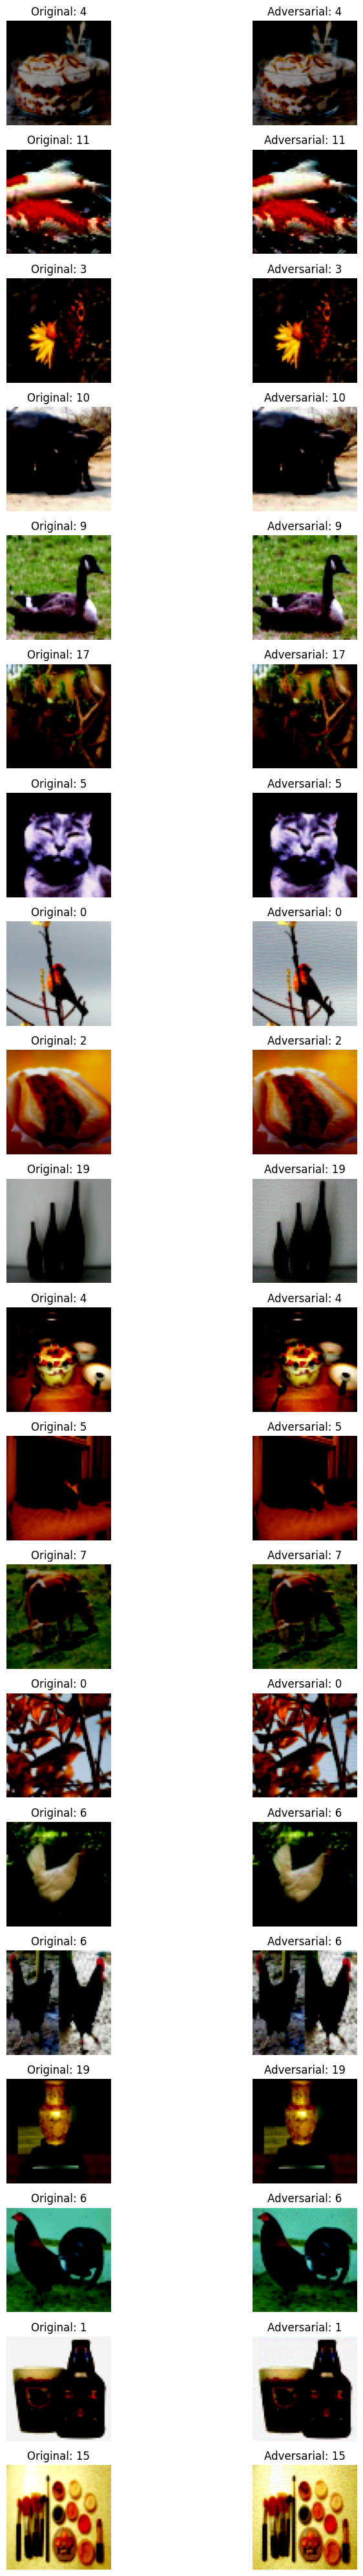

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def visualize_images(model, test_loader, epsilon=0.0313, alpha=0.002, num_steps=20, num_images=20):
    model.eval()

    images_list = []
    adversarial_images_list = []
    labels_list = []

    # Fetch a batch of images
    for images, labels in test_loader:
        if len(images_list) >= num_images:
            break
        images, labels = images.to(device), labels.to(device)

        # Perform the PGD attack
        adversarial_images = pgd_attack(model, images, labels, epsilon, alpha, num_steps)

        images_list.append(images.cpu())
        adversarial_images_list.append(adversarial_images.cpu())
        labels_list.append(labels.cpu())

    images = torch.cat(images_list)[:num_images]
    adversarial_images = torch.cat(adversarial_images_list)[:num_images]
    labels = torch.cat(labels_list)[:num_images]

    # Convert tensors to numpy arrays for visualization
    images = images.permute(0, 2, 3, 1).detach().numpy()
    adversarial_images = adversarial_images.permute(0, 2, 3, 1).detach().numpy()

    fig, axs = plt.subplots(num_images, 2, figsize=(10, num_images * 2))
    for i in range(num_images):
        axs[i, 0].imshow(images[i])
        axs[i, 0].set_title(f"Original: {labels[i].item()}")
        axs[i, 0].axis('off')

        axs[i, 1].imshow(adversarial_images[i])
        axs[i, 1].set_title(f"Adversarial: {labels[i].item()}")
        axs[i, 1].axis('off')

    plt.tight_layout()
    plt.show()

# Visualize original and adversarial images
visualize_images(model_with_ova, test_loader, epsilon=0.0313, alpha=0.002, num_steps=20, num_images=20)

<span style="color:red">**Question 3.7:**</span> **Train a robust model using adversarial training with PGD ${\epsilon= 0.0313, k=10, \eta= 0.002}$. Write the code for the adversarial training and report the robust accuracies. After finishing the training, you need to store your best robust model in the folder `./models` and load the model to evaluate the robust accuracies for PGD and FGSM attacks with $\epsilon= 0.0313, k=20, \eta= 0.002$ on the testing set.**
   
<div style="text-align: right"> <span style="color:red">[4 points]</span> </div>

In [ ]:
def train_with_adversarial_examples(model, train_loader, optimizer, epsilon=0.0313, alpha=0.002, num_steps=10, num_epochs=20, device='cpu'):
    model.to(device)
    model.train()

    for epoch in range(num_epochs):
        running_loss = 0.0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            # Generate adversarial examples
            adversarial_images = pgd_attack(model, images, labels, epsilon, alpha, num_steps)

            # Combine clean and adversarial examples
            combined_images = torch.cat([images, adversarial_images], dim=0)
            combined_labels = torch.cat([labels, labels], dim=0)

            # Forward pass
            optimizer.zero_grad()
            outputs = model(combined_images)
            loss = F.cross_entropy(outputs, combined_labels)

            # Backward and optimize
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * images.size(0)

        epoch_loss = running_loss / len(train_loader.dataset)
        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}')

# Initialize the model and optimizer
model = YourCNN(list_feature_maps = [16, 32, 64], use_skip = True)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Perform adversarial training
train_with_adversarial_examples(model, train_loader, optimizer, epsilon=0.0313, alpha=0.002, num_steps=10, num_epochs=20, device=device)

# Save the trained model
torch.save(model.state_dict(), './robust_model.pth')



Epoch 1/20, Loss: 2.8787
Epoch 2/20, Loss: 2.7359
Epoch 3/20, Loss: 2.6984
Epoch 4/20, Loss: 2.6601
Epoch 5/20, Loss: 2.5855
Epoch 6/20, Loss: 2.5083
Epoch 7/20, Loss: 2.4397
Epoch 8/20, Loss: 2.3715
Epoch 9/20, Loss: 2.3148
Epoch 10/20, Loss: 2.2751
Epoch 11/20, Loss: 2.2318
Epoch 12/20, Loss: 2.1849
Epoch 13/20, Loss: 2.1515
Epoch 14/20, Loss: 2.1216
Epoch 15/20, Loss: 2.0933
Epoch 16/20, Loss: 2.0614
Epoch 17/20, Loss: 2.0468
Epoch 18/20, Loss: 2.0095
Epoch 19/20, Loss: 1.9893
Epoch 20/20, Loss: 1.9709


In [ ]:
def fgsm_attack(model, images, labels, epsilon):
    model.eval()
    images, labels = images.to(device), labels.to(device)

    images.requires_grad = True
    outputs = model(images)
    loss = F.cross_entropy(outputs, labels)

    model.zero_grad()
    loss.backward()

    gradient = images.grad.data
    adversarial_images = images + epsilon * gradient.sign()
    adversarial_images = torch.clamp(adversarial_images, min=0, max=1)

    return adversarial_images

def evaluate_robustness(model, test_loader, epsilon=0.0313, alpha=0.002, num_steps=20, attack_type='pgd'):
    model.eval()
    correct = 0
    total = 0

    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)

        if attack_type == 'pgd':
            adversarial_images = pgd_attack(model, images, labels, epsilon, alpha, num_steps)
        elif attack_type == 'fgsm':
            adversarial_images = fgsm_attack(model, images, labels, epsilon)

        outputs = model(adversarial_images)
        _, predicted = torch.max(outputs, 1)

        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    accuracy = correct / total
    return accuracy

# Evaluate the robust accuracy for PGD attack
pgd_robust_accuracy = evaluate_robustness(model, test_loader, epsilon=0.0313, alpha=0.002, num_steps=20, attack_type='pgd')
print(f"Robust accuracy with PGD attack: {pgd_robust_accuracy*100:.2f}%")

# Evaluate the robust accuracy for FGSM attack
fgsm_robust_accuracy = evaluate_robustness(model, test_loader, epsilon=0.0313, attack_type='fgsm')
print(f"Robust accuracy with FGSM attack: {fgsm_robust_accuracy*100:.2f}%")


Robust accuracy with PGD attack: 17.95%
Robust accuracy with FGSM attack: 25.55%
